In [1]:

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

from __future__ import print_function
from pprint import pprint
from lightkurve import KeplerTargetPixelFile
import numpy as np
import matplotlib.pyplot as plt
import sncosmo
from astropy.table import Table
%matplotlib inline

In [110]:
tpf = KeplerTargetPixelFile.from_archive(220381074)   #KeplerTargetPixelFile
lc = tpf.to_lightcurve(aperture_mask='all')           #KeplerLightCurve

#Remove nans and outliers
lc = lc.remove_nans().remove_outliers()  
print(lc.flux)

[7916.004  7931.981  7910.661  ... 7843.703  7822.35   7789.4023]


In [102]:
import lightkurve.injection as inj
import lightkurve.lightcurve as lightcurve

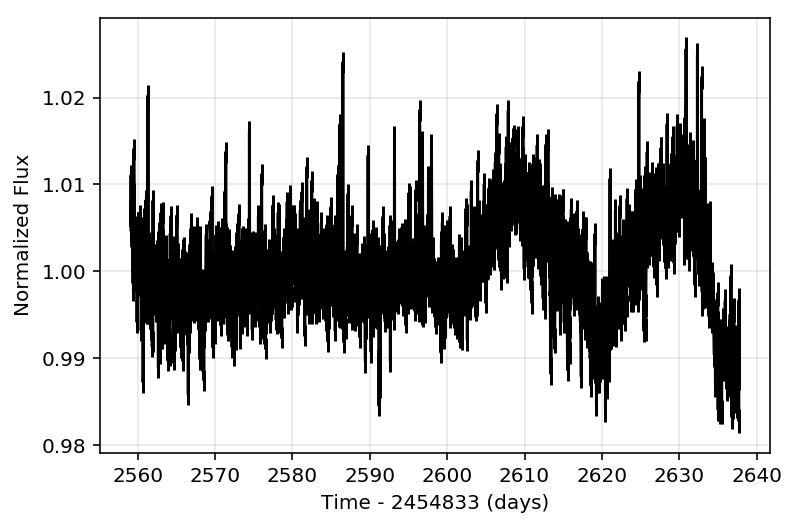

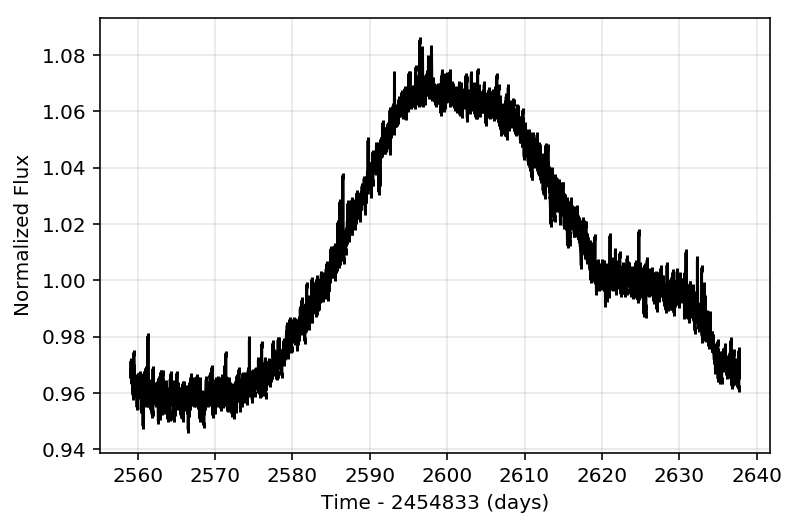

In [103]:
model = inj.SupernovaModel(T0=2600, source='hsiao', bandpass='kepler', z=0.5, amplitude=3.e-4)
lcinj = inj.inject(lc, model)
lc.plot()
lcinj.plot();

In [109]:
lcinj = lcinj.remove_nans()
lcinj = lcinj.normalize()

[1.0058376  1.0078677  1.0051588  ... 0.9966508  0.9939376  0.98975116]


In [105]:
fit = inj.recover_hsiao(lcinj)
print(fit)

[2.60000000e+03 5.00000000e-01 3.00000000e-04 9.56234024e-01]


In [112]:
model_fit = inj.SupernovaModel(T0=fit[0], source='hsiao', bandpass='kepler', z=fit[1], amplitude=fit[2])
model_eval = model_fit.evaluate(lc.time)

print(model_eval)
print(lc.flux)

model_eval = model_eval + np.nanmedian(lc.flux)
model_eval = model_eval / np.nanmedian(model_eval)
model_synth_fit = lightcurve.SyntheticLightCurve(lc.time, flux=model_eval)


[1.65486344e-17 1.65486344e-17 1.65486344e-17 ... 1.42834690e+02
 1.42705801e+02 1.42577141e+02]
[7916.004  7931.981  7910.661  ... 7843.703  7822.35   7789.4023]


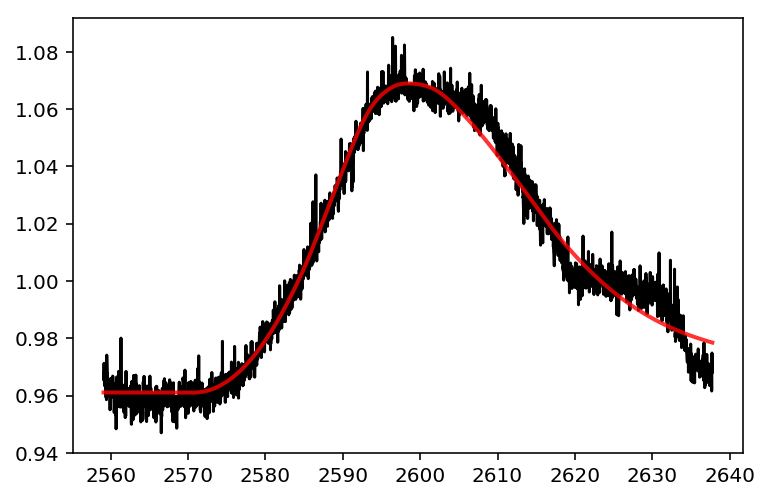

In [123]:
#lcinj.plot()
plt.plot(lc.time, lcinj.flux, color='k')
plt.plot(lc.time, model_synth_fit.flux, color='red', lw=2, ls='-',
        alpha=0.8)
#model_synth_fit.plot()